# Setting

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import spacy
from bs4 import BeautifulSoup

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [2]:
print('Pytorch version: ', torch.__version__)
print('Currently selected device: ', torch.cuda.current_device())
print('# GPUs available: ', torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu') # デバッグ用
print(device)

Pytorch version:  1.1.0
Currently selected device:  0
# GPUs available:  1
cuda:0


# Dataset作成に必要なclassおよびfunction

## 分かち書き

In [3]:
spacy_en = spacy.load('en')
def tokenizer(text):
    soup = BeautifulSoup(text)
    clean_txt = soup.get_text()
    words = []
    for token in spacy_en.tokenizer(clean_txt):
        if token.text not in "[],.();:<>{}|*-~":
            words.append(token.text)
    return words

## torknize

In [4]:
def df2indexseq(df, vocab_idx):
    data = []
    for text in df.values:
        words = tokenizer(text)
        data.append([vocab_idx[word] for word in words if word in vocab_idx.keys()])
    return data

## Padding

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, tags):
        super(MyDataset, self).__init__()
        assert len(data) == len(tags)
        # npに変換し、0埋めを行う
        max_length = max([len(d) for d in data])
        self.data = np.zeros((len(tags), max_length))
        for i, d1 in enumerate(data):
            for l, d2 in enumerate(d1):
                self.data[i][l] = d2
        self.tags = tags

    def __len__(self):
        return len(self.tags)

    def __getitem__(self, index):
        return self.data[index], self.tags[index]

# Model

## LSTM

In [6]:
class LSTM(nn.Module):
    def __init__(self, batch_size, vocab_size, emb_dim, hidden_dim, dropout_rate=0.0, activate='tanh', bidirectional=False, device='cpu'):
        super(LSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim    = emb_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.activate   = activate
        
        self.emb  = nn.Embedding(self.vocab_size, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first=True, bidirectional=self.bidirectional)
        
        self.fc0 = nn.Linear(hidden_dim * 2, 100)
        self.fc1 = nn.Linear(100, 2)
        self.do  = nn.Dropout(dropout_rate)
        self.device = device
        self.hidden = self.init_hidden()

    def forward(self, x):

        x = self.emb(x)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.fc0(torch.cat([self.hidden[0][-1], self.hidden[0][-2]], 1))
        y = self.do(y)
        if self.activate == 'tanh':
            y = self.fc1(F.tanh(y))
        elif self.activate == 'relu':
            y = self.fc1(F.relu(y))
        tag_scores = F.log_softmax(y)
        return tag_scores

    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        num = 2 if self.bidirectional else 1    # bidirectionalのとき2
        h0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(self.device)
        return (h0, c0)

## plot accuracy and loss

In [7]:
def training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    plt.figure()
    plt.plot(range(epoch_num), train_loss_list, color='blue', linestyle='-', label='train_loss')
    plt.plot(range(epoch_num), valid_loss_list, color='green', linestyle='--', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epoch_num), train_acc_list, color='blue', linestyle='-', label='train_acc')
    plt.plot(range(epoch_num), valid_acc_list, color='green', linestyle='--', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.grid()
    plt.show()

## Train

In [8]:
def training(net, train_loader, valid_loader, epoch_num, y_valid):

    train_loss_list = []
    train_acc_list  = []
    valid_loss_list = []
    valid_acc_list  = []
    
    for epoch in range(epoch_num):

        train_loss = 0.0
        train_acc  = 0.0
        valid_loss = 0.0
        valid_acc  = 0.0

        # train====================
        net.train()
        for xx, yy in train_loader:
            xx, yy = xx.long().to(device), yy.to(device)

            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            optimizer.zero_grad()    # 勾配の初期化

            output = net(xx)
            loss   = criterion(output, yy)

            train_loss += loss.item()
            train_acc += (output.max(1)[1] == yy).sum().item()

            loss.backward(retain_graph=True)     # 逆伝播の計算
            optimizer.step()    # 勾配の更新
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc  = train_acc  / len(train_loader.dataset)
            
        # eval========================
        net.eval()
        y_pred = []
        with torch.no_grad():
            for xx, yy in valid_loader:
                xx, yy = xx.long().to(device), yy.to(device)

                net.batch_size = len(yy)
                net.hidden = net.init_hidden()

                output = net(xx)
                loss   = criterion(output, yy)

                valid_loss += loss.item()
                valid_acc  += (output.max(1)[1] == yy).sum().item()
                y_pred += output.data.max(1, keepdim=True)[1].to('cpu').numpy()[:,0].tolist()
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc  = valid_acc  / len(valid_loader.dataset)
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

## Test

In [9]:
def test(net, test_loader, y_test):
    net.eval()
    y_pred = []
    with torch.no_grad():
        for xx, yy in test_loader:
            xx, yy = xx.long().to(device), yy.to(device)

            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            output = net(xx)
            y_pred += output.data.max(1, keepdim=True)[1].to('cpu').numpy()[:,0].tolist()

    acc = accuracy_score(y_pred, y_test)
    result = precision_recall_fscore_support(y_test, y_pred, average='macro')
    return [acc, result[0], result[1], result[2]]

# Results of GridSearch

In [10]:
gs_df = pd.read_csv('results/gridsearch_lstm_end2end.csv').sort_values('f1', ascending=False).head(5)
gs_df

,epoch,batch_size,embedding_dim,hidden_dim,activate_func,learning_rate,l2_regular,dropout_rate,accuracy,precision,recall,f1
581,300,64,300,200,tanh,0.1,0.001,0.25,0.963563,0.941310,0.880648,0.907931
617,300,64,300,200,tanh,0.1,0.001,0.50,0.962091,0.932360,0.882441,0.905305
491,300,64,300,100,relu,0.1,0.001,0.25,0.960986,0.921140,0.889703,0.904577
347,300,64,200,200,relu,0.1,0.001,0.00,0.960986,0.922186,0.888388,0.904312
455,300,64,300,100,relu,0.1,0.001,0.00,0.960986,0.925429,0.884443,0.903507


# Experiments

## Case0
original train and test data

In [11]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

vocab = []
for text in train_df.body.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(train_df.body, vocab_idx)
X_test  = df2indexseq(test_df.body, vocab_idx)
print('X_train shape', len(X_train))
print('X_test shape', len(X_test))

y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del train_df, test_df

vocabulaly size: 21100
X_train shape 8000
X_test shape 2717


LSTM(
  (emb): Embedding(21100, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


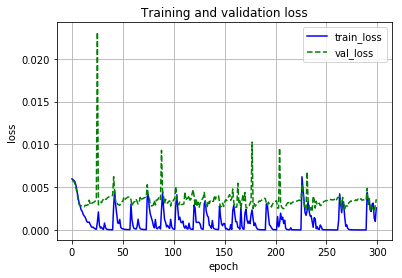

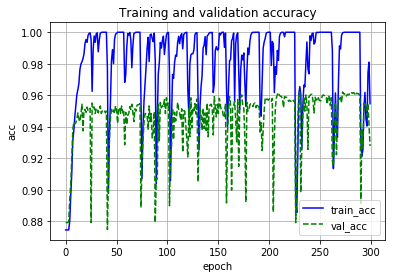

ValueError: too many values to unpack (expected 2)

In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [13]:
torch.save(net.state_dict(), 'best_params/lstm_original.prm')
del net, criterion, optimizer

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_original.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

FileNotFoundError: [Errno 2] No such file or directory: 'best_params/lstm_att_s2019.prm'

In [14]:
net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_original.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

Accuracy: 0.9591461170408538, Precision: 0.9041866595012347, Recall: 0.9031230538341382, F1: 0.9036538673490413


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Case1
the random seed of train_test_split is 2019

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=2019)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21089


LSTM(
  (emb): Embedding(21089, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


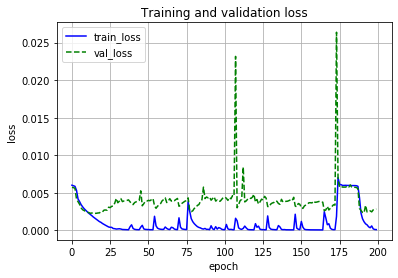

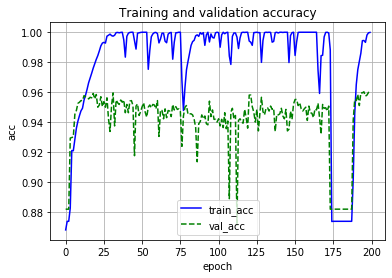

Accuracy: 0.9587780640412219, Precision: 0.9089791124928566, Recall: 0.8889458807254043, F1: 0.8986139986139986


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
torch.save(net.state_dict(), 'best_params/lstm_s2019.prm')
del net, criterion, optimizer

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_s2019.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.9587780640412219, Precision: 0.9089791124928566, Recall: 0.8889458807254043, F1: 0.8986139986139986


## Case2
the random seed of train_test_split is 2020

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=2020)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21170


LSTM(
  (emb): Embedding(21170, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


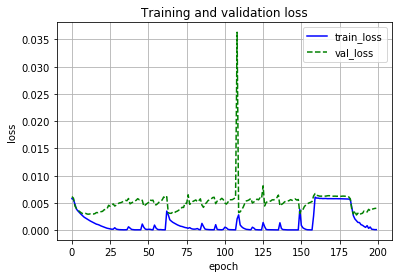

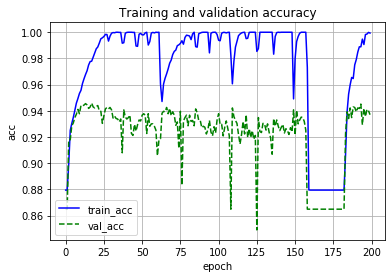

Accuracy: 0.9370629370629371, Precision: 0.8645372470894414, Recall: 0.8670479448083946, F1: 0.8657860368161323


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
torch.save(net.state_dict(), 'best_params/lstm_s2020.prm')
del net, criterion, optimizer

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_s2020.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

Accuracy: 0.9370629370629371, Precision: 0.8645372470894414, Recall: 0.8670479448083946, F1: 0.8657860368161323


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Case3
the random seed of train_test_split is 1996

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=1996)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21168


LSTM(
  (emb): Embedding(21168, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


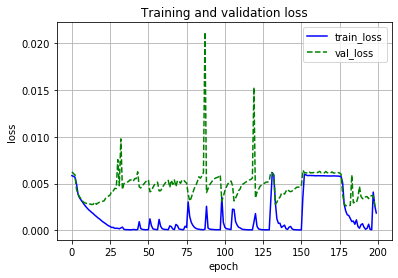

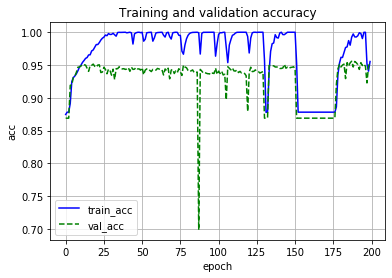

Accuracy: 0.9532572690467427, Precision: 0.9317545026146087, Recall: 0.8538326456605227, F1: 0.8873830166726229


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
torch.save(net.state_dict(), 'best_params/lstm_s1996.prm')
del net, criterion, optimizer

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_s1996.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.9532572690467427, Precision: 0.9317545026146087, Recall: 0.8538326456605227, F1: 0.8873830166726229


## Case4
the random seed of train_test_split is 1192

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=1192)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21125


LSTM(
  (emb): Embedding(21125, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


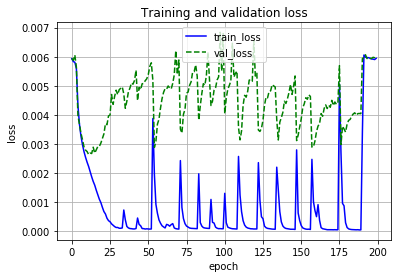

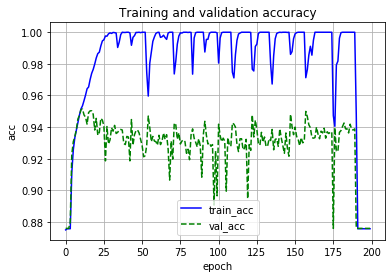

Accuracy: 0.8759661391240339, Precision: 0.43798306956201694, Recall: 0.5, F1: 0.4669413380419855


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
# torch.save(net.state_dict(), 'best_params/lstm_s1192.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_s1192.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

## Case5
the random seed of train_test_split is 794

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=794)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21174


LSTM(
  (emb): Embedding(21174, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


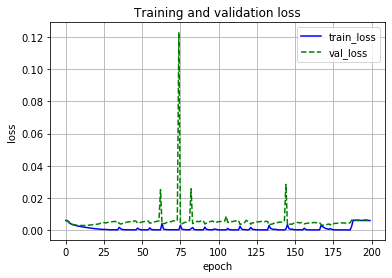

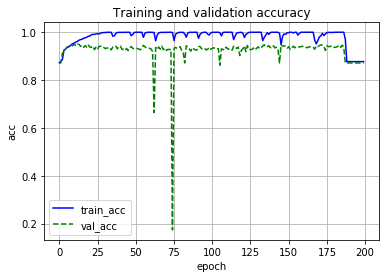

Accuracy: 0.8715495031284505, Precision: 0.43577475156422524, Recall: 0.5, F1: 0.4656833824975418


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
# torch.save(net.state_dict(), 'best_params/lstm_s794.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_s794.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

## Case6
the random seed of train_test_split is 2000

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=2000)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21241


LSTM(
  (emb): Embedding(21241, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


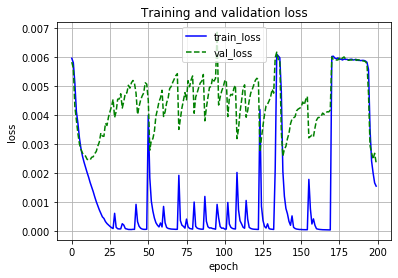

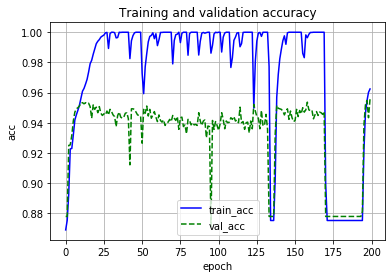

Accuracy: 0.9558336400441664, Precision: 0.9302762720755378, Recall: 0.8542793816776539, F1: 0.8872586039486461


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
torch.save(net.state_dict(), 'best_params/lstm_s2000.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_s2000.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.9558336400441664, Precision: 0.9302762720755378, Recall: 0.8542793816776539, F1: 0.8872586039486461


## Case7
the random seed of train_test_split is 1945

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=1945)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21204


LSTM(
  (emb): Embedding(21204, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


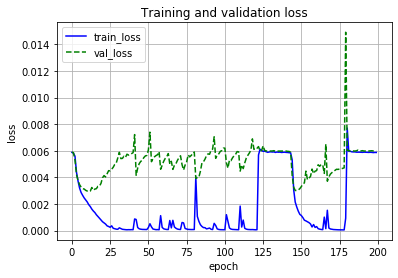

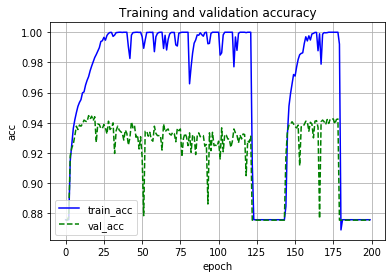

Accuracy: 0.8755980861244019, Precision: 0.43779904306220097, Recall: 0.5, F1: 0.46683673469387754


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
# torch.save(net.state_dict(), 'best_params/lstm_s1945.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_s1945.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

## Case8
the random seed of train_test_split is 5748

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=5748)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21085


LSTM(
  (emb): Embedding(21085, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


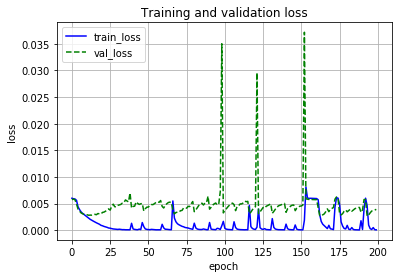

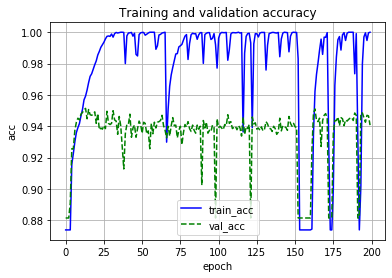

Accuracy: 0.9407434670592565, Precision: 0.8615492351650349, Recall: 0.8508020072874389, F1: 0.8560604639699536


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
torch.save(net.state_dict(), 'best_params/lstm_s5748.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_s5748.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.9407434670592565, Precision: 0.8615492351650349, Recall: 0.8508020072874389, F1: 0.8560604639699536


## Case9
the random seed of train_test_split is 7248

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=7248)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21087


LSTM(
  (emb): Embedding(21087, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


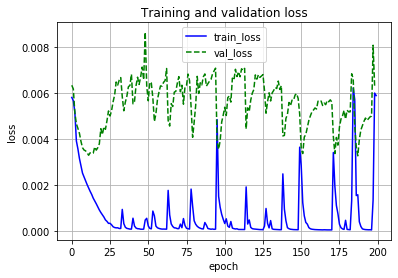

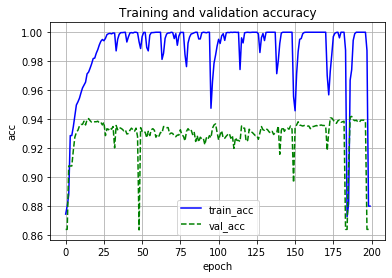

Accuracy: 0.8638203901361796, Precision: 0.4319101950680898, Recall: 0.5, F1: 0.46346761453396523


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [12]:
# torch.save(net.state_dict(), 'best_params/lstm_s7248.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_s7248.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

## Case10
the random seed of train_test_split is 8787

In [10]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]
total_df = pd.concat([train_df, test_df])

X = total_df.body
y = total_df.causal_flag.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=8787)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2indexseq(X_train, vocab_idx)
X_test  = df2indexseq(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)
del X_train, X_test

vocabulaly size: 21086


LSTM(
  (emb): Embedding(21086, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


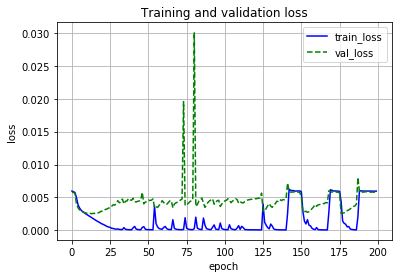

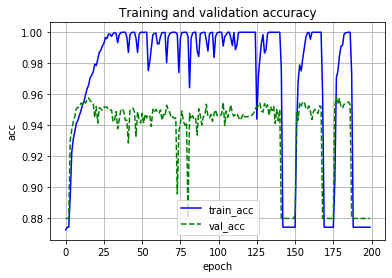

Accuracy: 0.8800147221199853, Precision: 0.44000736105999266, Recall: 0.5, F1: 0.4680892717306187


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [ ]:
# torch.save(net.state_dict(), 'best_params/lstm_s8787.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_s8787.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

# del net, train_ds, test_ds, train_loader, test_loader